# Custom Neural Style Transfer
Use VGG16 model to extract features and define your own network for style transfer. 



In [1]:
import tensorflow as tf
import re
import urllib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt
from IPython import display
from PIL import Image
import numpy as np
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K
from keras import backend as K
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


# Downloading images

In [2]:
def download_image_from_URL(imageURL):
  imageName = re.search('[a-z0-9\-]+\.(jpe?g|png|gif|bmp|JPG)', imageURL, re.IGNORECASE)
  imageName = imageName.group(0)
  urllib.request.urlretrieve(imageURL, imageName)
  imagePath = "./" + imageName
  return imagePath

In [3]:
# This is the path to the image you want to transform.
target_url = "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/blank-sign.jpg" #@param ["https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/blank-sign.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/close-squirrel.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/escalante.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/ferns.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/flowers.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/large-pumpkin.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/on-the-road.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/road.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/seychelles-flora.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/tractor.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/wild-flowers.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/among-giants.jpg"]
target_path = download_image_from_URL(target_url)
# This is the path to the style image.
style_url = "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/road.jpg" #@param ["https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/road.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/blank-sign.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/close-squirrel.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/escalante.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/ferns.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/flowers.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/large-pumpkin.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/on-the-road.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/seychelles-flora.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/tractor.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/wild-flowers.jpg", "https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch12/among-giants.jpg"]
style_path = download_image_from_URL(style_url) 

## Defining dimensions for the target image

In [4]:
# Dimensions for the generated picture.
width, height = load_img(target_path).size
img_height = 400
img_width = int(width * img_height / height)

##Displaying Content and Style images

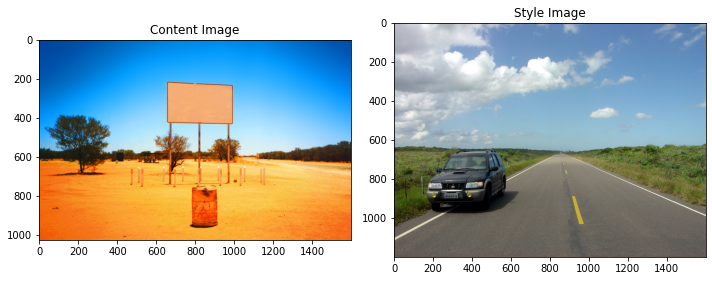

In [5]:
content = Image.open(target_path)
style = Image.open(style_path)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title('Style Image')

plt.tight_layout()
plt.show()

# Data preparation

In [6]:
# Preprocess the data as per VGG16 requirements
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

# Inverse processing

VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68] and having channels BGR. 

Furthermore, since our optimized image may take  values anywhere between  −∞  and  ∞ , we must clip those to maintain them in the 0-255 range.

In [7]:
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Create inputs for the VGG16 model. 
We need to input all three images, viz. content, style and random generated image. 

In [8]:
target = K.constant(preprocess_image(target_path))
style = K.constant(preprocess_image(style_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target,
                              style,
                              combination_image], axis=0)

## Build the Model

The model is loaded with pre-trained ImageNet weights. The input is a batch of 3 images. The model extracts the feature maps for content and style representations. The generated image is improved upon on every iteration. 

Note that by setting include_top=False in the code below, we don't include any of the fully connected layers.

In [9]:
# Build the VGG16 network with our batch of 3 images as input.
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(3, 400, 621, 3)]        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 621, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 621, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 310, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 310, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 310, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 155, 128)        0     

## Content Loss
Compute content loss for the generated image


In [11]:
# compute content loss for the generated image
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

## Style Loss
Use gram matrix to get the correlation between channels, which ultimately act a measure of the style itself. 

In [12]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# Total variation loss

In [13]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# Selecting VGG16 layers for content and style

In [14]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Name of layer used for content loss
content_layer = 'block5_conv2'

# Name of layers used for style loss;
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Computing Loss

In [15]:
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 10.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)


# Function to compute loss and gradients in one pass

In [16]:
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

# Generating Stylized image
Use L-BGFS (Limited Memory Broyden–Fletcher–Goldfarb–Shanno) optimizer

In [17]:
iterations = 50

x = preprocess_image(target_path)
x = x.flatten()
for i in range(1, iterations):
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, 
                                     x,
                                     fprime=evaluator.grads, 
                                     maxfun=10)
    print('Iteration %0d, loss: %0.02f' %(i, min_val))
img = x.copy().reshape((img_height, img_width, 3))
img = deprocess_image(img)

Iteration 1, loss: 15942903808.00
Iteration 2, loss: 2904517376.00
Iteration 3, loss: 1508827392.00
Iteration 4, loss: 1040013056.00
Iteration 5, loss: 784535616.00
Iteration 6, loss: 627631424.00
Iteration 7, loss: 493457728.00
Iteration 8, loss: 408117312.00
Iteration 9, loss: 352164000.00
Iteration 10, loss: 304529312.00
Iteration 11, loss: 268585312.00
Iteration 12, loss: 235324944.00
Iteration 13, loss: 212460528.00
Iteration 14, loss: 191959952.00
Iteration 15, loss: 174056448.00
Iteration 16, loss: 160641600.00
Iteration 17, loss: 147952304.00
Iteration 18, loss: 137716288.00
Iteration 19, loss: 127713808.00
Iteration 20, loss: 119244624.00
Iteration 21, loss: 110663872.00
Iteration 22, loss: 102146784.00
Iteration 23, loss: 97069120.00
Iteration 24, loss: 93145936.00
Iteration 25, loss: 87844672.00
Iteration 26, loss: 83610272.00
Iteration 27, loss: 81008320.00
Iteration 28, loss: 78366792.00
Iteration 29, loss: 74735216.00
Iteration 30, loss: 71539176.00
Iteration 31, loss: 68

# Displaying all three images  

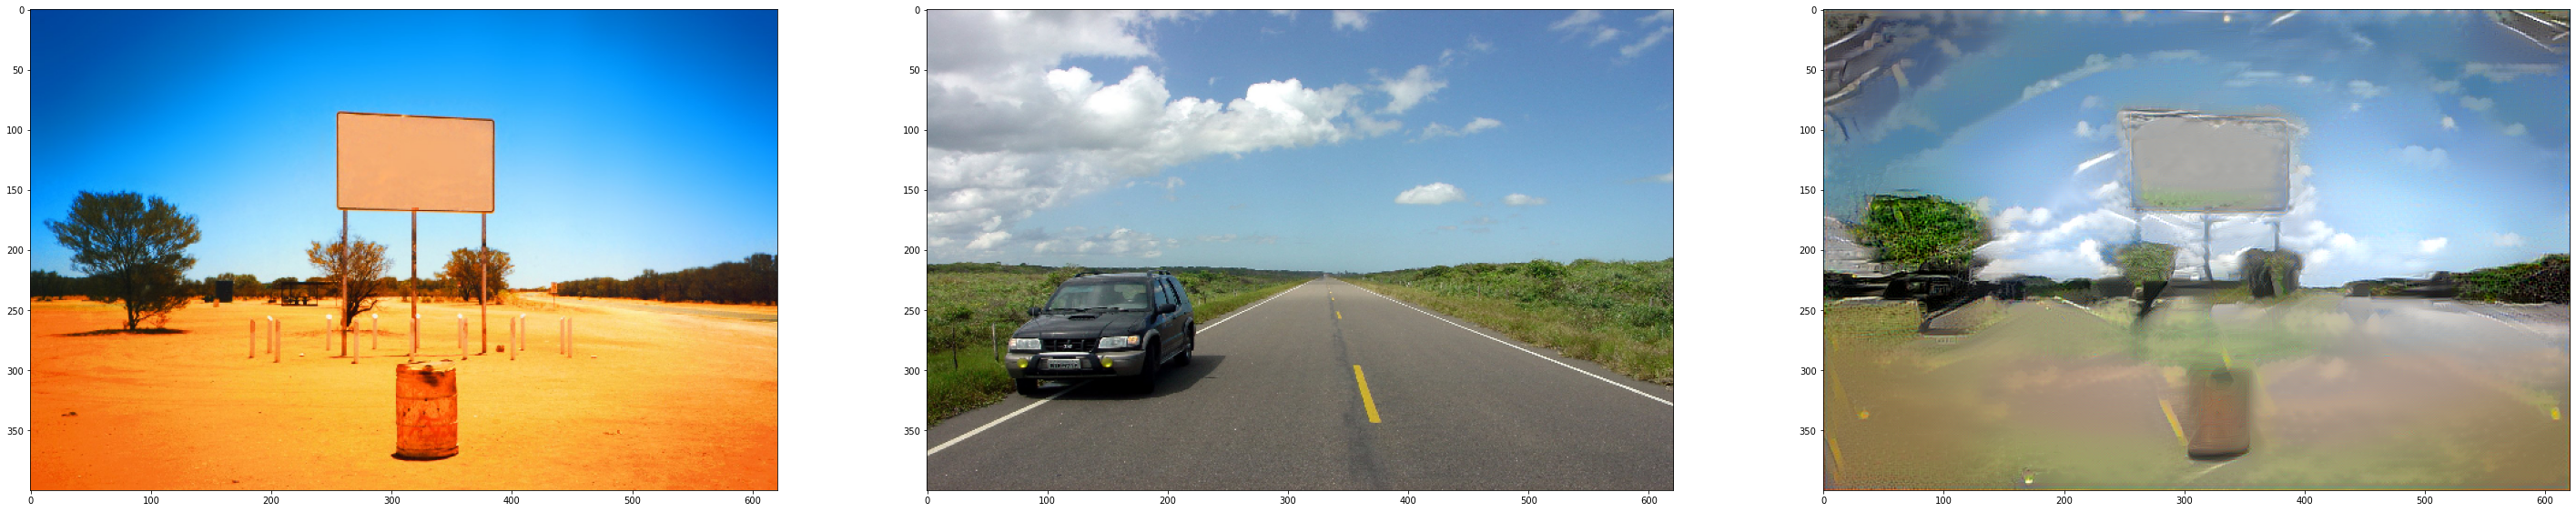

In [18]:
plt.figure(figsize=(50, 50)) 

plt.subplot(3,3,1)
plt.imshow(load_img(target_path, target_size=(img_height, img_width)))

plt.subplot(3,3,2)
plt.imshow(load_img(style_path, target_size=(img_height, img_width)))

plt.subplot(3,3,3)
plt.imshow(img)

plt.show()